In [1]:
from cmtj import CVector, Layer, Junction, ScalarDriver, AxialDriver, NullDriver
from tqdm import tqdm
import math
from scipy.signal import butter, lfilter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
vsd2p = pd.read_csv("./VSD/5360_2p.csv", sep='\t')
vsd4p = pd.read_csv("./VSD/5360_4p.csv", sep='\t')

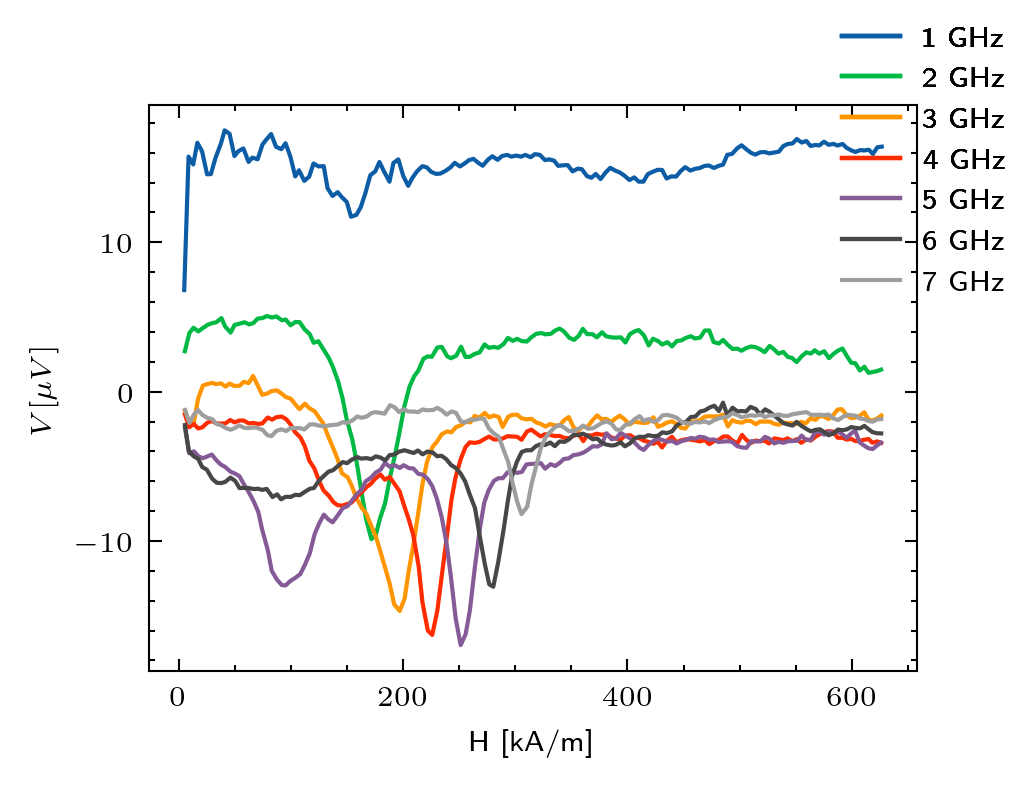

In [3]:
OeToAm = 79.57747
with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(dpi=300)
    for f in np.arange(1, 8):
        ax.plot(vsd2p[f"2pf_{f}.0_GHz"] * OeToAm / 1e3,
                vsd2p[f"2pf_{f}.0_GHz.1"] * 1e6,
                label=f"{f} GHz")
        ax.set_xlabel("H [kA/m]")
        ax.set_ylabel(r"$V [\mu V]$")
        fig.legend()


In [4]:
import cmtj

Rx0 = [304.306]
Ry0 = [1.008]
SMR = [-0.464]
AMR = [-0.053]
AHE = [-5.71] 
w = [2e-5]
l = [3e-5]


def butter_bandpass_filter(data, pass_freq, fs, order=5):
    nyq = 0.5 * fs
    if pass_freq == 0:
        pass_freq = 0.1
    try:
        b, a = butter(order, [0.9 * pass_freq / nyq, pass_freq / nyq],
                      btype='bandpass',
                      analog=False)
    except ValueError:
        print(fs, pass_freq, nyq, 0.9 * pass_freq / nyq, pass_freq / nyq)
        raise ValueError("Error in filtering")
    y = lfilter(b, a, data, zi=None)
    return y


def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data, zi=None)
    return y


def calculate_resistance(Rx0, Ry0, AMR, AHE, SMR, m, number_of_layers, l, w):
    if m.ndim == 2:
        SxAll = np.zeros((number_of_layers, ))
        SyAll = np.zeros((number_of_layers, ))

    elif m.ndim == 3:
        SxAll = np.zeros((number_of_layers, m.shape[2]))
        SyAll = np.zeros((number_of_layers, m.shape[2]))

    for i in range(0, number_of_layers):
        w_l = w[i] / l[i]
        SxAll[i] = 1 / (Rx0[i] + (AMR[i] * m[i, 0]**2 + SMR[i] * m[i, 1]**2))
        SyAll[i] = 1 / (Ry0[i] + 0.5 * AHE[i] * m[i, 2] + (w_l) *
                        (SMR[i] - AMR[i]) * m[i, 0] * m[i, 1])

    Rx = 1 / np.sum(SxAll, axis=0)
    Ry = 1 / np.sum(SyAll, axis=0)
    return Rx, Ry


def compute_vsd1(stime, resistance, frequency, tstart=2e-9):
    """Time"""
    stime = np.asarray(stime)
    indx = np.argwhere(stime >= tstart).ravel()
    Rx = np.asarray(resistance)[indx]
    avg_res = np.mean(Rx)
    current = np.sqrt(1 / avg_res) * np.sin(
        2 * np.pi * frequency * stime[indx])
    return np.mean(current * Rx)


def compute_vsd2(dynamicR, integration_step, dynamicI):
    """Pymag"""
    SD = -dynamicI * dynamicR
    fs = 1.0 / integration_step
    SD_dc = butter_lowpass_filter(SD, cutoff=10e6, fs=fs, order=3)
    return np.mean(SD_dc)


def compute_vsd_scan(Ms,
                     Ku,
                     orient='4p',
                     silent=False,
                     hnum=40,
                     fstep=0.5,
                     int_step=4e-12,
                     stime=20e-9):
    demagTensor = [
        CVector(0., 0., 0.),
        CVector(0., 0., 0.),
        CVector(0., 0., 1.0)
    ]
    damping = 30e-3
    thickness = 1.45e-9
    l1 = Layer(id="free",
               mag=CVector(0., 0., 1.),
               anis=CVector(0, 0., 1.),
               Ms=Ms,
               thickness=thickness,
               cellSurface=0,
               demagTensor=demagTensor,
               damping=damping)
    junction = Junction([l1])

    junction.setLayerAnisotropyDriver("free",
                                      ScalarDriver.getConstantDriver(Ku))

    HoeAmpl = 5000  # A/m
    Hspace = np.linspace(000e3, 600e3, num=hnum)
    frequencies = np.arange(2, 20, fstep) * 1e9
    VSD = []
    Irf = 10e-3
    theta = np.deg2rad(91)
    if orient == '4p':
        phideg = 1
    elif orient == '2p':
        phideg = 45
    else:
        raise ValueError("Unknown orient")

    phi = np.deg2rad(phideg)
    for frequency in tqdm(frequencies, disable=silent):
        H_sweep = []
        for H in Hspace:
            junction.clearLog()
            HDriver = AxialDriver(
                ScalarDriver.getConstantDriver(H * math.sin(theta) *
                                               math.cos(phi)),
                ScalarDriver.getConstantDriver(H * math.sin(theta) *
                                               math.sin(phi)),
                ScalarDriver.getConstantDriver(H * math.cos(theta)))

            HoeDriver = AxialDriver(
                NullDriver(),
                ScalarDriver.getSineDriver(0, HoeAmpl, frequency, 0),
                NullDriver())
            junction.setLayerExternalFieldDriver("all", HDriver)
            junction.setLayerOerstedFieldDriver("all", HoeDriver)
            junction.runSimulation(stime,
                                   int_step,
                                   int_step,
                                   solverMode=cmtj.RK4)

            log = junction.getLog()
            m = np.asarray(
                [[log[f'{str_}_mx'], log[f'{str_}_my'], log[f'{str_}_mz']]
                 for str_ in ['free']])
            dynamicRx, dynamicRy = calculate_resistance(Rx0=Rx0,
                                                        Ry0=Ry0,
                                                        AMR=AMR,
                                                        AHE=AHE,
                                                        SMR=SMR,
                                                        m=m,
                                                        number_of_layers=1,
                                                        l=l,
                                                        w=w)
            if orient == '2p':
                dynamicR = dynamicRx
            else:
                dynamicR = dynamicRy
            dynamicI = Irf * \
                        np.sin(2 * math.pi * frequency * np.asarray(log['time']))
            vmix = compute_vsd2(dynamicR, int_step, dynamicI)
            H_sweep.append(vmix)
        VSD.append(H_sweep)
    VSD = np.asarray(VSD)
    return VSD, frequencies, Hspace, phideg

In [5]:
import cmtj
from collections import defaultdict

Rx0 = [304.306]
Ry0 = [1.008]
SMR = [-0.464]
AMR = [-0.053]
AHE = [-5.71]
w = [2e-5]
l = [3e-5]


def simulate_lorentz(Ms, Ku, frequency, orient, alpha=1e-4, Irf=0.5e-3):
    demagTensor = [
        CVector(0., 0., 0.),
        CVector(0., 0., 0.),
        CVector(0., 0., 1.0)
    ]
    thickness = 1.45e-9
    l1 = Layer(id="free",
               mag=CVector(0., 0., 1.),
               anis=CVector(0, 0., 1.),
               Ms=Ms,
               thickness=thickness,
               cellSurface=0,
               demagTensor=demagTensor,
               damping=alpha)
    junction = Junction([l1])

    junction.setLayerAnisotropyDriver("free",
                                      ScalarDriver.getConstantDriver(Ku))

    HoeAmpl = 5000  # A/m
    Hspace = np.linspace(350e3, 630e3, num=100)
    int_step = 1e-12
    theta = np.deg2rad(91)
    if orient == '4p':
        phideg = 0
    elif orient == '2p':
        phideg = 45
    else:
        raise ValueError("Unknown orient")
    phi = np.deg2rad(phideg)
    Hsweep = np.zeros((Hspace.shape[0]))
    for i, H in enumerate(Hspace):
        junction.clearLog()
        HDriver = AxialDriver(
            ScalarDriver.getConstantDriver(H * math.sin(theta) *
                                           math.cos(phi)),
            ScalarDriver.getConstantDriver(H * math.sin(theta) *
                                           math.sin(phi)),
            ScalarDriver.getConstantDriver(H * math.cos(theta)))

        HoeDriver = AxialDriver(
            NullDriver(), NullDriver(),
            ScalarDriver.getSineDriver(0, -HoeAmpl, frequency, 0))
        junction.setLayerExternalFieldDriver("all", HDriver)
        junction.setLayerOerstedFieldDriver("all", HoeDriver)
        junction.runSimulation(40e-9, int_step, int_step, solverMode=cmtj.RK4)

        log = junction.getLog()
        m = np.asarray(
            [[log[f'{str_}_mx'], log[f'{str_}_my'], log[f'{str_}_mz']]
             for str_ in ['free']])
        dynamicRx, dynamicRy = calculate_resistance(Rx0=Rx0,
                                                    Ry0=Ry0,
                                                    AMR=AMR,
                                                    AHE=AHE,
                                                    SMR=SMR,
                                                    m=m,
                                                    number_of_layers=1,
                                                    l=l,
                                                    w=w)
        if orient == '2p':
            dynamicR = dynamicRx
        else:
            dynamicR = dynamicRy
        dynamicI = Irf * \
                    np.sin(2 * math.pi * frequency * np.asarray(log['time']))
        vmix = compute_vsd2(dynamicR, int_step, dynamicI)
        Hsweep[i] = vmix
    return Hspace, Hsweep


data = defaultdict(list)
hscans = []
vscans = []
fscan = np.arange(12, 17)
# orient = '4p'
alpha = 30e-3
for orient, irf in zip(('4p', '2p'), (0.75e-3, 0.5e-3)):
    for f in tqdm(fscan):
        hscan, vscan = simulate_lorentz(0.525,
                                        1.54e5,
                                        f * 1e9,
                                        orient=orient,
                                        alpha=alpha,
                                        Irf=irf)
        if orient == '2p':
            vscan -= vscan.max()
        data[f'{orient}'].append(vscan)
        data[f'{orient}-field'].append(hscan)


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


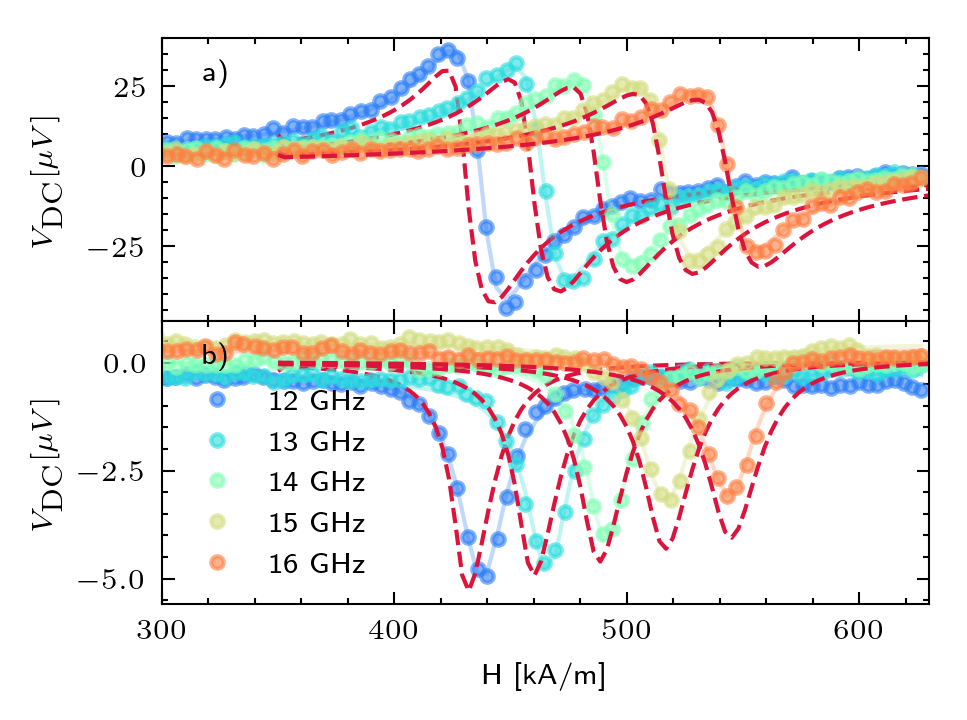

In [6]:
from scipy.optimize import curve_fit
import seaborn as sns


def lorentz_fit(H, dH, Hr, Va, Vs, Vb):
    dH2 = (dH**2)
    HHr = H - Hr
    denom = 4 * (HHr**2) + dH2
    nom = Va * HHr * dH + Vs * dH2
    return Vb + nom / denom


OeToAm = 79.57747
with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(2, 1, dpi=300, sharex='col')
    rainbow = sns.color_palette('rainbow', len(fscan))
    for j, orient in enumerate(('4p', '2p')):
        for i, f in enumerate(fscan):
            if orient == '2p':
                H = (vsd2p[f"2pf_{f}.0_GHz"] * OeToAm / 1e3).dropna()
                V = (vsd2p[f"2pf_{f}.0_GHz.1"] * 1e6).dropna()
            else:
                H = (vsd4p[f"4pf_{f}.0_GHz"] * OeToAm / 1e3).dropna()
                V = (vsd4p[f"4pf_{f}.0_GHz.1"] * 1e6).dropna()
            ax[j].plot(
                H,
                V,
                'o',
                label=f"{f} GHz",
                alpha=0.6,
                color=rainbow[i],
                markersize=3,
            )
            Hr = H[V.argmin()]
            popt, pcov = curve_fit(lorentz_fit,
                                   xdata=H,
                                   ydata=V,
                                   p0=(0.1, Hr, 0, 0, 0))
            ax[j].plot(H, lorentz_fit(H, *popt), color=rainbow[i], alpha=0.3)
            ax[j].plot(np.asarray(data[f"{orient}-field"][i]) / 1e3,
                       np.asarray(data[orient][i]) * 1e6,
                       alpha=1,
                       linestyle='--',
                       color='crimson',
                       linewidth=1)
        ax[j].set_xlim([300, 630])
        ax[j].set_ylabel(r"$V_\textrm{DC} [\mu V]$")

    ax[1].set_xlabel("H [kA/m]")
    ax[1].legend()
    import matplotlib.transforms as mtransforms
    for label, ax in zip(['a)', 'b)'], ax.flatten()):
        trans = mtransforms.ScaledTranslation(10 / 72, -5 / 72,
                                              fig.dpi_scale_trans)
        ax.text(0.0,
                1.0,
                label,
                transform=ax.transAxes + trans,
                fontsize='medium',
                verticalalignment='top',
                bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
    fig.subplots_adjust(hspace=0)
    fig.align_ylabels()

# Fitting the VSD maps

18 18 17 17


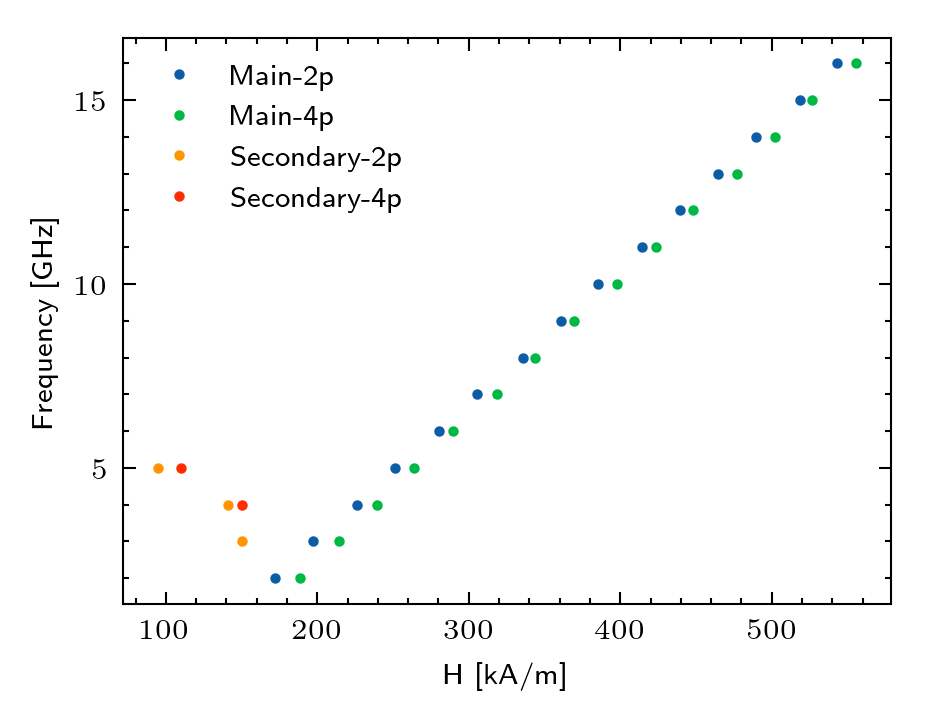

In [8]:
def signal_modes(signal):
    signal_indx = signal.argsort()
    return signal_indx[:2]


main_line_2p = []
main_line_4p = []
second_peak_2p = [150, 141, 95]
second_peak_2p_f = np.arange(3, 6)
second_peak_4p = [150, 110]
second_peak_4p_f = np.arange(4, 6)
freqs = np.arange(2, 17)
for f in freqs:
    Hs = vsd2p[f"2pf_{f}.0_GHz"] * OeToAm / 1e3
    minima = signal_modes(vsd2p[f"2pf_{f}.0_GHz.1"].values)
    main_line_2p.append(Hs[minima[0]])

    Hs = vsd4p[f"4pf_{f}.0_GHz"] * OeToAm / 1e3
    minima = signal_modes(vsd4p[f"4pf_{f}.0_GHz.1"].values)
    main_line_4p.append(Hs[minima[0]])

ensemble_2p_f = np.concatenate((second_peak_2p_f, freqs))
ensemble_4p_f = np.concatenate((second_peak_4p_f, freqs))

ensemble_2p = second_peak_2p + main_line_2p
ensemble_4p = second_peak_4p + main_line_4p
print(len(ensemble_2p_f), len(ensemble_2p), len(ensemble_4p),
      len(ensemble_4p_f))
with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(dpi=300)
    ax.plot(main_line_2p, freqs, marker='.', linestyle='', label='Main-2p')
    ax.plot(main_line_4p, freqs, marker='.', linestyle='', label='Main-4p')
    ax.plot(second_peak_2p,
            second_peak_2p_f,
            marker='.',
            linestyle='',
            label='Secondary-2p')
    ax.plot(second_peak_4p,
            second_peak_4p_f,
            marker='.',
            linestyle='',
            label='Secondary-4p')
    ax.set_xlabel("H [kA/m]")
    ax.set_ylabel("Frequency [GHz]")
    ax.legend()

In [9]:
Ms = 0.525
Ku = 1.54e5
VSD, frequencies, Hspace, phideg = compute_vsd_scan(Ms, Ku, orient='2p')
VSD4p, frequencies4p, Hspace4p, phideg4p = compute_vsd_scan(Ms,
                                                            Ku,
                                                            orient='4p')


100%|██████████| 36/36 [00:05<00:00,  7.05it/s]


/var/folders/wq/0q9brtfs5rq65q1t_mtgshb00000gn/T/ipykernel_71906/1579870633.py:7: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.

/var/folders/wq/0q9brtfs5rq65q1t_mtgshb00000gn/T/ipykernel_71906/1579870633.py:8: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.



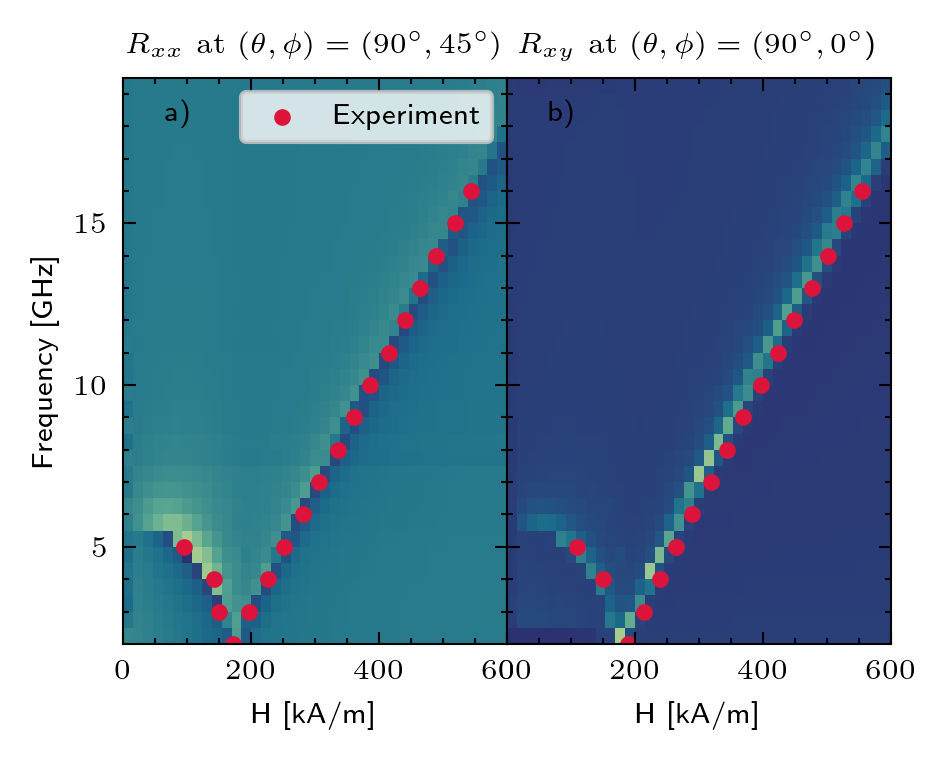

In [10]:
import seaborn as sns

crest = sns.color_palette('crest', as_cmap=True)
with plt.style.context(['science', 'nature']):
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=300, sharey=True)
    VSD_plot = (VSD.T - np.median(VSD, axis=1).T).T
    im = ax1.pcolormesh(Hspace / 1e3, frequencies / 1e9, VSD_plot, cmap=crest)
    im = ax2.pcolormesh(Hspace / 1e3, frequencies / 1e9, VSD4p, cmap=crest)
    ax1.scatter(ensemble_2p,
                ensemble_2p_f,
                label='Experiment',
                color='crimson')
    ax2.scatter(ensemble_4p,
                ensemble_4p_f,
                label='Experiment',
                color='crimson')
    for ax_ in (ax1, ax2):
        ax_.set_xlabel("H [kA/m]")
    ax1.set_ylabel("Frequency [GHz]")
    ax1.legend(facecolor='white', frameon=True)
    ax1.set_title(
        r"$R_{xx} \textrm{ at } (\theta, \phi)=(90^\circ, 45^\circ)$",
        fontsize=7)
    ax2.set_title(r"$R_{xy} \textrm{ at } (\theta, \phi)=(90^\circ, 0^\circ$)",
                  fontsize=7)
    import matplotlib.transforms as mtransforms
    for label, ax in zip(['a)', 'b)'], (ax1, ax2)):
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10 / 72, -5 / 72,
                                              fig.dpi_scale_trans)
        ax.text(0.0,
                1.0,
                label,
                transform=ax.transAxes + trans,
                fontsize='medium',
                verticalalignment='top',
                bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
    fig.subplots_adjust(wspace=0)

# MSE analysis

In [11]:
from cmtj import CVector, Layer, Junction, ScalarDriver, AxialDriver, NullDriver
from tqdm import tqdm
import math
import time
from scipy.signal import butter, lfilter
from multiprocess import Pool
from functools import partial


def butter_bandpass_filter(data, pass_freq, fs, order=5):
    nyq = 0.5 * fs
    if pass_freq == 0:
        pass_freq = 0.1
    try:
        b, a = butter(order, [0.9 * pass_freq / nyq, pass_freq / nyq],
                      btype='bandpass',
                      analog=False)
    except ValueError:
        print(fs, pass_freq, nyq, 0.9 * pass_freq / nyq, pass_freq / nyq)
        raise ValueError("Error in filtering")
    y = lfilter(b, a, data, zi=None)
    return y


def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data, zi=None)
    return y


def compute_vsd(dynamicR, integration_step, dynamicI):
    SD = -dynamicI * dynamicR
    fs = 1.0 / integration_step
    SD_dc = butter_lowpass_filter(SD, cutoff=10e6, fs=fs, order=3)
    return np.mean(SD_dc)


def compute_vsd_scan(Ms, Ku, int_step=1e-11):
    demagTensor = [
        CVector(0., 0., 0.),
        CVector(0., 0., 0.),
        CVector(0., 0., 1.0)
    ]
    damping = 0.03
    thickness = 1.45e-9
    l1 = Layer(id="free",
               mag=CVector(0., 0., 1.),
               anis=CVector(0, 0., 1.),
               Ms=Ms,
               thickness=thickness,
               cellSurface=0,
               demagTensor=demagTensor,
               damping=damping)
    junction = Junction([l1])

    junction.setLayerAnisotropyDriver("free",
                                      ScalarDriver.getConstantDriver(Ku))

    HoeAmpl = 1500  # A/m
    Hspace = np.linspace(000e3, 400e3, num=20)
    frequencies = np.arange(2, 15, 0.5) * 1e9
    VSD = []
    Irf = 10e-3
    # int_step = 1e-11
    theta = np.deg2rad(92)
    phideg = 3
    phi = np.deg2rad(phideg)
    for frequency in frequencies:
        H_sweep = []
        for H in Hspace:
            junction.clearLog()
            HDriver = AxialDriver(
                ScalarDriver.getConstantDriver(H * math.sin(theta) *
                                               math.cos(phi)),
                ScalarDriver.getConstantDriver(H * math.sin(theta) *
                                               math.sin(phi)),
                ScalarDriver.getConstantDriver(H * math.cos(theta)))

            HoeDriver = AxialDriver(
                NullDriver(),
                ScalarDriver.getSineDriver(0, HoeAmpl, frequency, 0),
                NullDriver())
            junction.setLayerExternalFieldDriver("all", HDriver)
            junction.setLayerOerstedFieldDriver("all", HoeDriver)
            junction.runSimulation(8e-9, int_step, int_step)

            log = junction.getLog()
            m = np.asarray(
                [[log[f'{str_}_mx'], log[f'{str_}_my'], log[f'{str_}_mz']]
                 for str_ in ['free']])
            dynamicRx, dynamicRy = calculate_resistance(Rx0=Rx0,
                                                        Ry0=Ry0,
                                                        AMR=AMR,
                                                        AHE=AHE,
                                                        SMR=SMR,
                                                        m=m,
                                                        number_of_layers=1,
                                                        l=l,
                                                        w=w)
            dynamicI = Irf * \
                        np.sin(2 * np.pi * frequency * np.asarray(log['time']))
            vmix = compute_vsd(dynamicRy, int_step, dynamicI)
            H_sweep.append(vmix)
        VSD.append(H_sweep)

    return VSD, frequencies, Hspace


def parallel_scan(Kui, Ms_space, VSD_comp, freqs):
    Ku, ki = Kui
    VSD_data = []
    VSD_mse = []
    for Ms in Ms_space:
        VSD, _, _ = compute_vsd_scan(Ms, Ku)
        VSD = np.asarray(VSD)
        VSD_data.append(VSD)
        VSD_mse.append(mse_(VSD, VSD_comp, freqs=freqs))

    return np.asarray(VSD_data), np.asarray(VSD_mse), ki


N = 100
eps = 0.4
Ms = 0.52
Ku = 1.44e5

N = 200
eps = 0.3
Ms = 0.525
Ku = 1.54e5

main_line, freqs, hspace = compute_vsd_scan(Ms, Ku)
main_line = np.asarray(main_line)


def mse_(lineA, lineB, freqs):
    freq_line = freqs[lineA.argmin(axis=0)]
    main_freq_line = freqs[lineB.argmin(axis=0)]
    return np.power(freq_line - main_freq_line, 2).sum()


Ms_space = np.linspace((1 - eps) * Ms, (1 + eps) * Ms, N)
# Ku_space = np.linspace((1 - eps) * Ku, (1 + eps) * Ku, N)
# Ms_space = np.linspace()
Ku_space = np.linspace(0.13e6, 0.18e6, 30)
VSD_data = np.zeros((len(Ku_space), len(Ms_space), *main_line.shape))
VSD_mse = np.zeros((len(Ku_space), len(Ms_space)))

with Pool(8) as pool:
    with tqdm(total=len(Ku_space)) as pbar:
        for result in pool.imap_unordered(
                partial(parallel_scan,
                        Ms_space=Ms_space,
                        VSD_comp=main_line,
                        freqs=freqs), zip(Ku_space, np.arange(len(Ku_space)))):
            VSD1, VSD2, ki = result
            VSD_data[ki, :] = VSD1
            VSD_mse[ki, :] = VSD2
            pbar.update()

100%|██████████| 30/30 [07:23<00:00, 14.79s/it]


/var/folders/wq/0q9brtfs5rq65q1t_mtgshb00000gn/T/ipykernel_71906/3335917866.py:20: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.



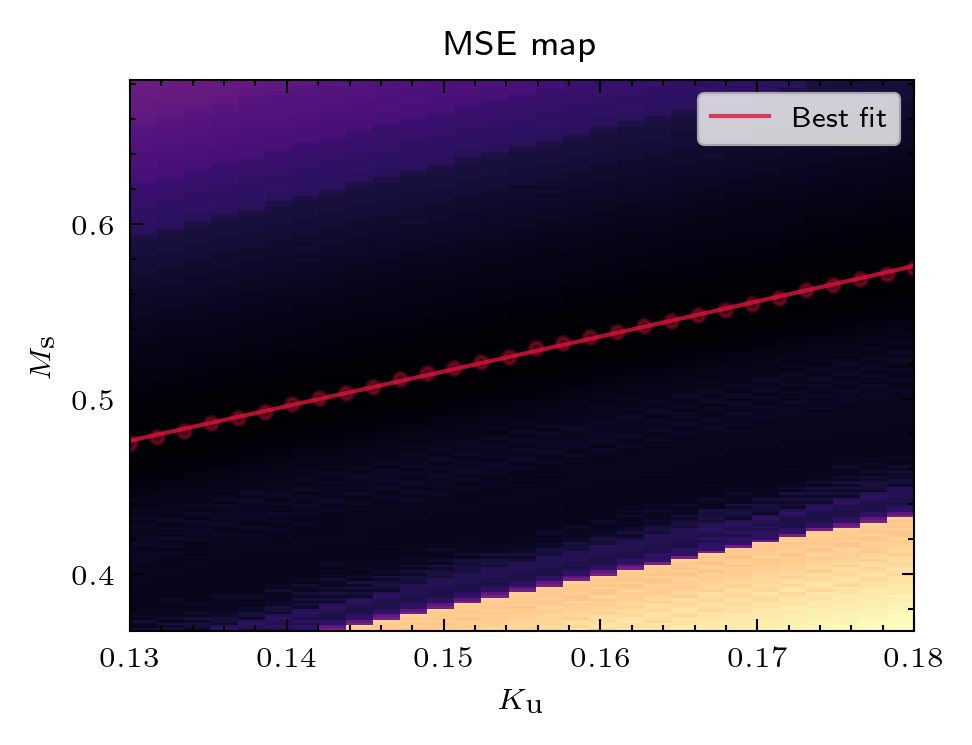

In [12]:
def fn(x, a, b, c, d):
    return a * np.power(b, (x / c)) + d


min_line = VSD_mse.argmin(axis=1)  # shape 200
Ms_min = Ms_space[min_line]
y = Ms_min
X = Ku_space
popt, _ = curve_fit(fn, X, y)

magma = sns.color_palette('magma', as_cmap=True)
with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(dpi=300)
    ax.plot(X / 1e6, y, 'o', color='crimson', alpha=0.3)
    ax.plot(X / 1e6,
            fn(X, *popt),
            color='crimson',
            alpha=0.8,
            label='Best fit')
    im = ax.pcolormesh(Ku_space / 1e6, Ms_space, VSD_mse.T, cmap=magma)
    ax.set_title(r"MSE map")
    ax.set_xlabel(r"$K_\textrm{u}$")
    ax.set_ylabel(r"$M_\textrm{s}$")
    ax.legend(frameon=True)
    fig.tight_layout()

In [13]:
Ku_ = np.asarray([0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18]) * 1e6
Ms_ = fn(Ku_, *popt)
lines = []
for K_, M_ in zip(tqdm(Ku_), Ms_):
    ML, freqs, hspace = compute_vsd_scan(M_, K_, int_step=4e-12)
    lines.append(np.asarray(ML))

100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


/var/folders/wq/0q9brtfs5rq65q1t_mtgshb00000gn/T/ipykernel_71906/3071572444.py:16: RuntimeWarning:

divide by zero encountered in log

/var/folders/wq/0q9brtfs5rq65q1t_mtgshb00000gn/T/ipykernel_71906/3071572444.py:14: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.



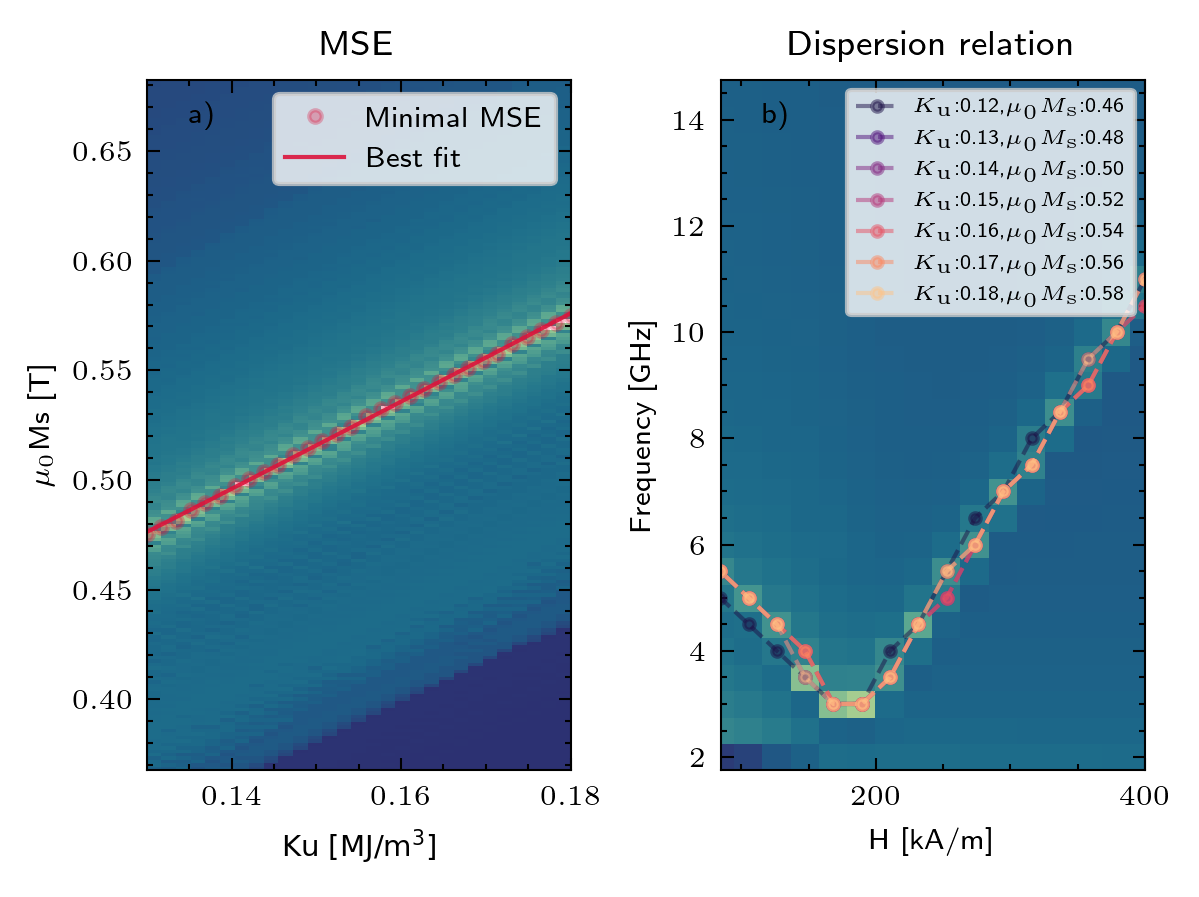

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

with plt.style.context(['science', 'nature']):
    magma = sns.color_palette('magma', len(lines))
    crest = sns.color_palette('crest', as_cmap=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 3), dpi=300)

    ax1.plot(X / 1e6, y, 'o', color='crimson', alpha=0.3, label='Minimal MSE')
    ax1.plot(X / 1e6,
             fn(X, *popt),
             color='crimson',
             alpha=0.9,
             label='Best fit')
    im = ax1.pcolormesh(Ku_space / 1e6,
                        Ms_space,
                        np.log(VSD_mse.T),
                        cmap=crest)

    ax1.set_title(r"MSE")
    ax1.set_xlabel("Ku [$\mathregular{MJ/m^3}$]", usetex=False)
    ax1.set_ylabel(r"$\mathdefault{\mu_\mathrm{0}}$Ms [T]")

    for i, (line, K, M) in enumerate(zip(lines, Ku_, Ms_)):
        min_line = freqs[line.argmin(axis=0)]
        ax2.plot(
            hspace / 1e3,
            min_line / 1e9,
            '.--',
            color=magma[i],
            alpha=0.5,
            markersize=5,
            label=r"$\mathdefault{K}_\textrm{u}$:" +
            f"{K/1e6:.2f}," +
            r"$\mu_\textrm{0}\mathdefault{M}_\textrm{s}$:" + f"{M:.2f}")
        ax2.pcolor(hspace / 1e3, freqs / 1e9, line, cmap=crest, shading='auto')
    ax2.set_xlabel("H [kA/m]")
    ax2.set_xlim([85, 400])
    ax2.set_ylabel("Frequency [GHz]")
    ax2.set_title("Dispersion relation")

    import matplotlib.transforms as mtransforms
    for label, ax in zip(['a)', 'b)'], (ax1, ax2)):
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10 / 72, -5 / 72,
                                              fig.dpi_scale_trans)
        ax.text(
            0.0,
            1.0,
            label,
            transform=ax.transAxes + trans,
            fontsize='medium',
            verticalalignment='top',
            # fontfamily='serif',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
    ax1.legend(frameon=True, loc=0)
    ax2.legend(frameon=True, facecolor='w', prop={'size': 5}, loc=1)

    fig.tight_layout()
    # fig.align_ylabels()
